In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read as wavread
import IPython.display as display
from scipy.fftpack import fft
from matplotlib.animation import FuncAnimation
from IPython import display
import ipywidgets as widgets

# Using STFT to create Chroma Features
Converting audio to a visible representation of musical notes requires analyzing the audio over brief time windows to gather frequency data many times to show changes in the frequency makeup of the audio. Understanding the relationship between frequency and musical pitch is crucial to this process.

The relationship is a logarithmic relationship with base 2.


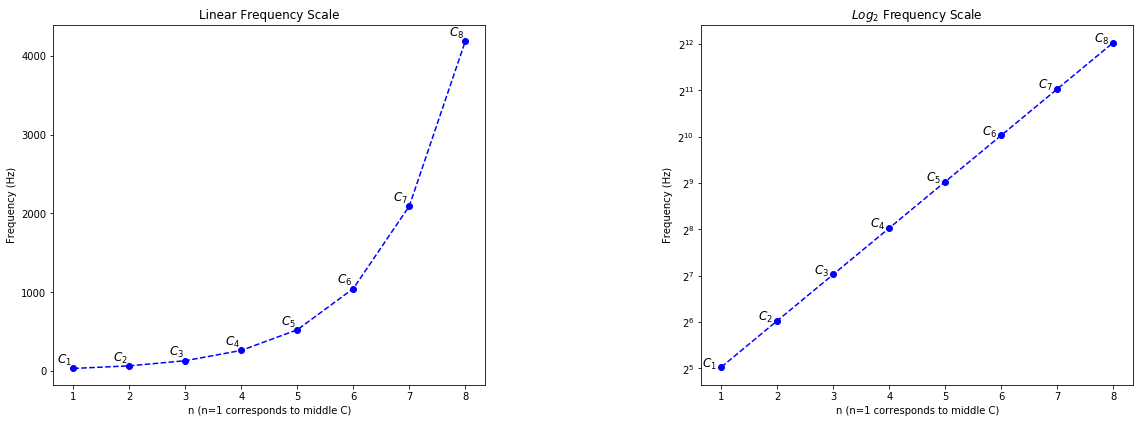

In [2]:
notes = [32.7032, 65.4064, 130.813, 261.626, 523.251, 1046.50, 2093.00, 4186.01]
n = [1,2,3,4,5,6,7,8]
label = ['$C_1$', "$C_2$","$C_3$","$C_4$","$C_5$","$C_6$","$C_7$","$C_8$"]
plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1,position=[1,1,.5,1])
ax2 = plt.subplot(1,2,2,position=[1.75,1,.5,1])

ax1.set_title("Linear Frequency Scale")
ax1.scatter(n, notes, color='blue')
ax1.plot(n,notes,'b--')
ax1.set_xlabel("n (n=1 corresponds to middle C)")
ax1.set_ylabel("Frequency (Hz)")

ax2.set_title("$Log_2$ Frequency Scale")
ax2.set_xlabel("n (n=1 corresponds to middle C)")
ax2.set_ylabel("Frequency (Hz)")
ax2.set_yscale('log', basey=2)
ax2.scatter(n, notes, color='blue')
ax2.plot(n,notes, 'b--')


for i, txt in enumerate(notes):
    ax1.annotate(label[i], (n[i]-.3, notes[i]+60), fontsize = 12)
    ax2.annotate(label[i], (n[i]-.35, notes[i]), fontsize = 12)

plt.show()

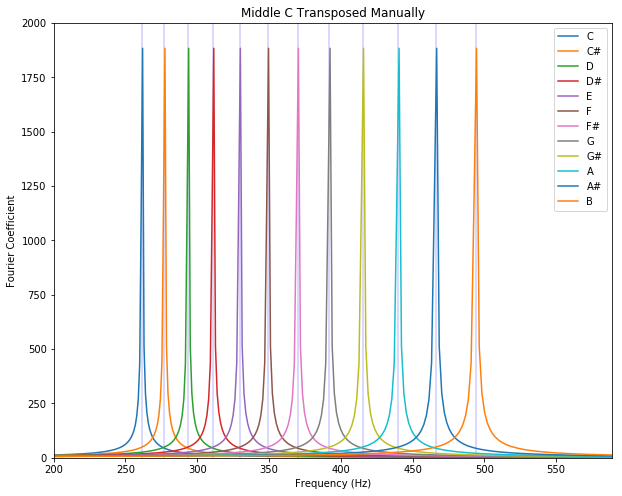

In [3]:
h = 1/4800
x = np.arange(0,1,h)
N = len(x)

fNy = 1//(2*h)
freq = 261.626 
#frequency resolution is 1 by choice
ang_freq = freq*2*np.pi
middle_C = np.sin(ang_freq*x) #pure middle C
r = 2**(1/12) #frequency ratio of neighboring pitches

fftdata = fft(middle_C)
C = fftdata[:int(fNy)]

plt.figure(figsize=(10,8) )
frange =np.arange(0,int(fNy),1)
plt.xlim(200,2.25*freq)
plt.ylim(0,2000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier Coefficient")
notes = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
for i in range(12):
    plt.plot(frange*r**(i),abs(C), label = notes[i]) #changing the x-values each time to transpose by a semitone
plt.title("Middle C Transposed Manually")


pitches = [261.626, 277.183, 293.665, 311.127, 329.628, 349.228, 369.994, 391.995, 415.305, 440.000, 466.164, 493.883]
plt.vlines(pitches, 0,2000, colors ='b', alpha=0.2)
plt.legend()
plt.show()

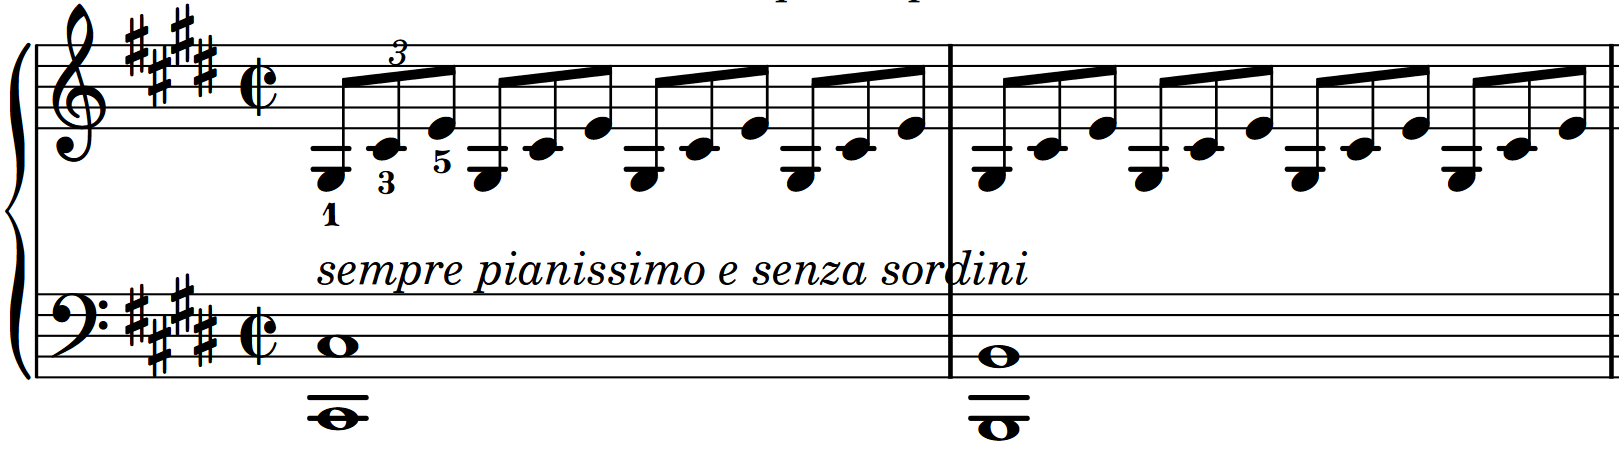

In [4]:
rate, data = wavread("Moonlight Sonata First Two Measures.wav")
# import data of music


slicedData = data[0:-15000,0]+data[0:-15000,1]
# sliced the first 2 measures
# added the left and right channels


display.Audio(slicedData, rate=rate)



## Creating the Spectrogram

In [5]:


def spec_graph(f,t,x, title): #graphing the spectrogram
    # x is complex so we take the absolute value
    plt.figure(figsize=[15,6])
    plt.pcolormesh(t, f, np.abs(x),vmin = 0,vmax = 500000, cmap = "Greys")
    # plotting the spectogram
    # not logarithmic compressed


    plt.xlabel("Time (sec)")
    plt.ylabel("Frequency (Hz)")
   
    plt.title(title)


    plt.ylim(0,2000)


    plt.show()
    



### Center Frequency
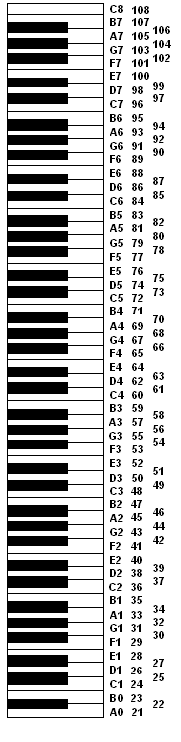
Every piano note can be represented electronically by a MIDI pitch with and associated number, as seen in the image above. Each of these MIDI pitches can be converted to a frequency with the function seen below.

In [6]:
#k_array = np.arange(0, len(f), 1) # array of frequency indices


def centfreq(p): # relation between frequency and MIDI pitches
    return (2**((p-69)/12))*(0.440)*1000


    


### STFT
The Short-Time Fourier Tranform, or STFT, is a way to convert data to a frequency representation. It works by performing a FFT over short time periods and then putting them together. The nperseg (n per segment) is how many data points per window during calculations. A higher nperseg means that you will have a lower time resolution and higher frequency resolution.

Using a different framing function for the window, called a "Window Function" produces results whose characteristics vary.



In [7]:
def stft(data, windowlen, rate, windowtype = "Rectangular"):
    if(windowtype == "Rectangular"):#This will manipulate the data at each slice to give different weights to values
        w = 1
    if(windowtype == "Hann"): #Hann is a window which goes to zero at the ends of the window, putting higher weight on the data
        u = np.linspace(-.5,.5,windowlen)#in the center of the window
        w = (1+np.cos(np.pi*u))/2
    hop = windowlen//2
    M = np.arange(0,len(data)//hop-1, dtype=int)
    n = np.arange(windowlen)
    K_arr = np.arange(0,windowlen//2, dtype = int)
    Chi = np.empty((len(M),len(K_arr)), dtype=complex)
    for m in M:
        x = data[m*hop:windowlen+m*hop]
        chi_m = fft(w*x)[:windowlen//2] #two notes here. First, we multiply by the window function before using fft.
                                        #second, for efficiency, we only calculate coefficients up to the nyquist frequency
        
        Chi[m,:] = chi_m
    F_arr = (K_arr*rate/windowlen)
    T_arr = (M*hop/rate)
    return abs(F_arr), abs(T_arr), abs(Chi.T)




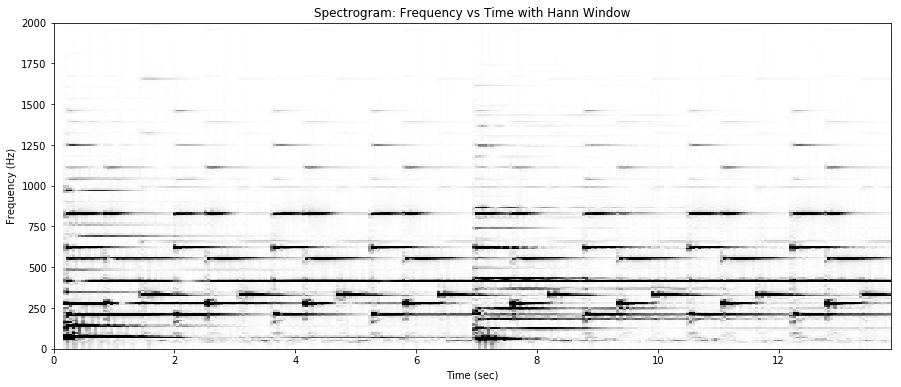

2500


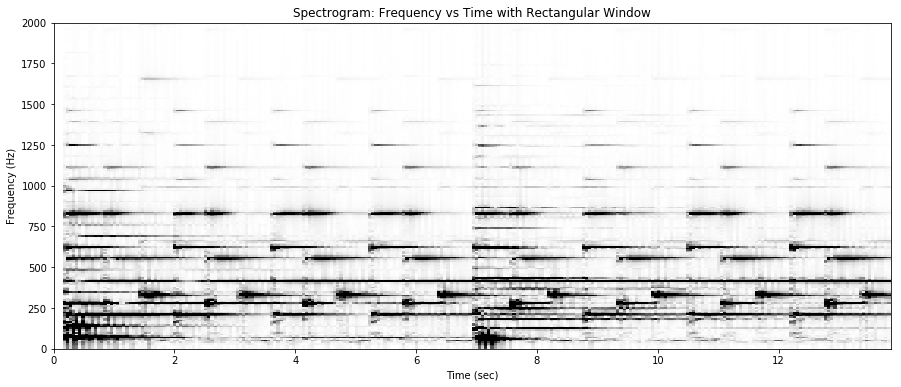

In [8]:


# windowlen is relatively high so that we get better freq. resolution 
# at the expense of time resolution
# rectangular window is default for our function, but Hann window can yield fewer "ripples" in the coefficients
#at the cost of smearing the frequencies a bit
#It looks like the smearing is less pronounced than the ripples, which show up at each time slice in the 
#rectangular version as significant coefficients in frequencies in the neighborhood of the ones being played.
f, t, x = stft(slicedData,5000,rate, windowtype = "Hann")
spec_graph(f, t, x,"Spectrogram: Frequency vs Time with Hann Window")

print(len(x))
windowlen = 5000
fres = rate/windowlen
# sampling rate = rate / window length

f2,t2,x2 = stft(slicedData,5000,rate)
spec_graph(f2,t2,x2,"Spectrogram: Frequency vs Time with Rectangular Window")


The STFT gives us an array of frequencies, and the pitch function will give us the indices for all frequencies which are contained in the desired MIDI pitch. To calculate the these indices, we found all frequences that are within 0.5 MIDI pitch of the desired note and collected them. We'll continue on using the Hann window version of our spectrogram.

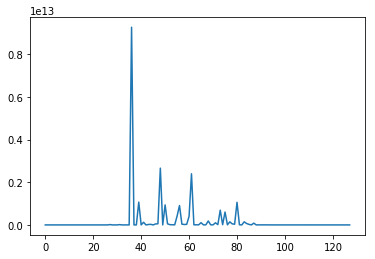

In [9]:

def pitch(p, f, t):        # a set of frequency indices for every pitch, p
    fcoef = f.copy() # physical frequency of each fourier coeffiecent
    tcoef = t.copy() # time position of each fourier coefficient
    stuff = []
    f1 = centfreq(p-0.5)
    #print(f1)
    f2 = centfreq(p+0.5)
    #print(f2)
    # array of frequencies
    for i in range(0, len(fcoef)):
        element = fcoef[i]
        if element >= f1 and element < f2:
            stuff.append(i)
        
    return np.array(stuff)
 
def y(n, p, f, t): # calculate ylf (log-frequency spect) at particular point (n,p)
    p1 = pitch(p,f,t)
    xcurr = x[:,n] # stft at time step n
    thesum = 0 # return value for log-frequency spectogram
    
    for i in range(len(p1)):
        thesum += (np.abs(xcurr[p1[i]]))**2 # add up fourier coefficients at frequency indices associated with pitch p
    return thesum
#for some time slice n, and some desired pitch p, we calculate a value representing that pitch's prevalence at that time.
#Then, at one time slice n, we run the function above for ALL midi pitches to get all of their contributions.
def graph_freq(n, f, t): #graphs how much each note contributes at time slice n
    ylf_values = [] # list of ylf at each point (n,p)
    p_array = np.arange(0, 128, 1) # all pitches of MIDI pitch scale
    
    for i, p_prime in enumerate(p_array):
        ylf_values.append(y(n, p_prime, f, t)) # at time step n
    ylf_array = np.array(ylf_values)
    

    plt.plot(p_array, ylf_array) 
    plt.show()
graph_freq(10,f,t)

Then, we produce the Spectrogram of MIDI pitch vs time rather than Frequency vs time by running graph_freq function over all time of the file and graphing it.

In [10]:

n_values = np.arange(0, len(t), 1) # index time slices (number of time slice arrays in 2D array, x)
p_values = np.arange(0, 128, 1) # all pitches of MIDI pitch scale
spectrogram = np.empty((len(p_values), len(n_values)))
t_values = t.copy()    
for i, time in enumerate(t_values):
    for j, p in enumerate(p_values):
        spectrogram[j,i] = y(i, p, f, t)


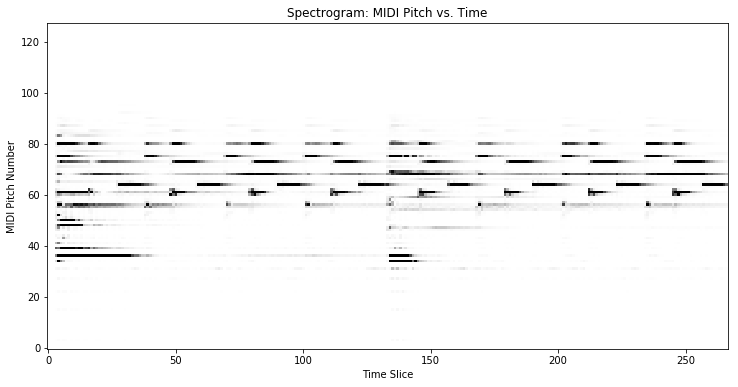

In [11]:
plt.figure(figsize=(15, 6))
#plt.axhline(y=37, color="black", xmin=0, xmax=500, alpha=0.2, linestyle="--")
#plt.axhline(y=39, color="black", xmin=0, xmax=500, alpha=0.2, linestyle="--")
#plt.axhline(y=34, color="black", xmin=0, xmax=500, alpha=0.2, linestyle="--")
#plt.axhline(y=36, color="black", xmin=0, xmax=500, alpha=0.2, linestyle="--")
#plt.axhline(y=46, color="black", xmin=0, xmax=500, alpha=0.2, linestyle="--")
#plt.axhline(y=82, color="black", xmin=0, xmax=500, alpha=0.2, linestyle="--")
plt.imshow(spectrogram, origin="lower", cmap="Greys", vmin=0, vmax=950000000000)
plt.xlabel("Time Slice")
plt.ylabel("MIDI Pitch Number")
plt.title("Spectrogram: MIDI Pitch vs. Time")
plt.show()

## Crafting a Chromagram
        So far, we have shown when each pitch appears in the piece of music. To simplify the display, we will represent each
        octave of a note (called a chroma) together as a single note.
        Ex. C = [C0, C1, C2, ...], which is the set of all octaves of a note
        
        We then add up the spectrogram values for each octave of a note to create the simplified chromagram.

In [12]:
def chroma(n, c):
    chromaSum = 0
    p_values = np.arange(0, 128, 1) # all pitches of MIDI pitch scale
    p_array = p_values.copy()
    
    pitchclass = p_array[(p_array%12==c)]
    
    chromaSum = np.sum(spectrogram[pitchclass,n])
    return chromaSum

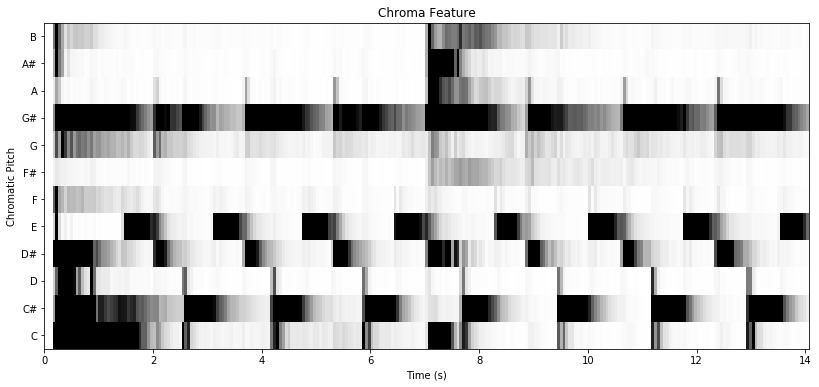

In [13]:
t_values = t.copy()
c_values = np.arange(0, 12, 1)
chromagram = np.empty((len(c_values), len(t_values)))
for i, time in enumerate(t_values):
    for j, c in enumerate(c_values):
        chromagram[j,i] = chroma(i, c)

plt.figure(figsize=(15, 6))
plt.imshow(chromagram, origin="lower", cmap="Greys", vmin=400000, vmax=1000000000000, aspect=.5, extent =[0,14.0625,-.5,11.5])
#plt.imshow(chromagram, origin="lower", cmap="Greys", aspect=8)
labels = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
plt.yticks(np.linspace(0,11,12),labels)
plt.ylabel("Chromatic Pitch")
plt.xlabel("Time (s)")
plt.title("Chroma Feature")

plt.show()

## Logarithmic Compression
        In music processing, it is advantageous to bring out the subtle notes of a song and tame the "louder" notes to have a           more complete representation of the song.

In [14]:
def logwidget(gamma):
    row = len(chromagram[:,0])

    column = len(chromagram[0,:])
    logcompr = np.log(np.ones((row, column)) + gamma*chromagram) #This literally compresses the coefficients of frequencies
                                                                #not quite the same as dynamic compression, which would simply
    plt.figure(figsize=(15, 6))                                 #take the data of the file and reduce its magnitude
    plt.imshow(logcompr, origin="lower", cmap="Greys", vmin=29, vmax=35, aspect=.5, extent =[0,14.0625,-.5,11.5])

    labels = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    plt.yticks(np.linspace(0,11,12),labels)
    plt.ylabel("Chromatic Pitch")
    plt.xlabel("Time (s)")
    plt.title("Chroma Feature (Logarithmic Compression)")
    plt.show()
gui = widgets.interactive(logwidget, gamma =widgets.IntSlider(min=50,max =1000,step = 50, value = 500,description = "$\gamma$"), continuousupdate = "false")
display.display(gui)

interactive(children=(IntSlider(value=500, description='$\\gamma$', max=1000, min=50, step=50), Output()), _do…

## Normalization of Chromagram
    As you saw in the above chromagram, the notes fade over time. 
    We would like to have a distinct segment representating each note in the chromagram for clarity. 
    To do this, we define a threshold for intensity of the chromagram to create a distinction from music and background.

In [15]:
def norm(array):
    normsum = 0
    for i in range(0, len(array)):
        normsum += (np.abs(array[i]))**2
    return np.sqrt(normsum)    



def projection(array, eps):
    thenorm = norm(array)
    if thenorm > eps:
        return array/thenorm
    else:
        return (np.ones(len(array)))/(np.sqrt(12))
    
eps = 1000
t_values = t.copy()
c_values = np.arange(0, 12, 1)
new = np.zeros((len(c_values), len(t_values)))
for i, time in enumerate(t_values):
    array = chromagram[:, i]
    new[:,i] = projection(array, eps)

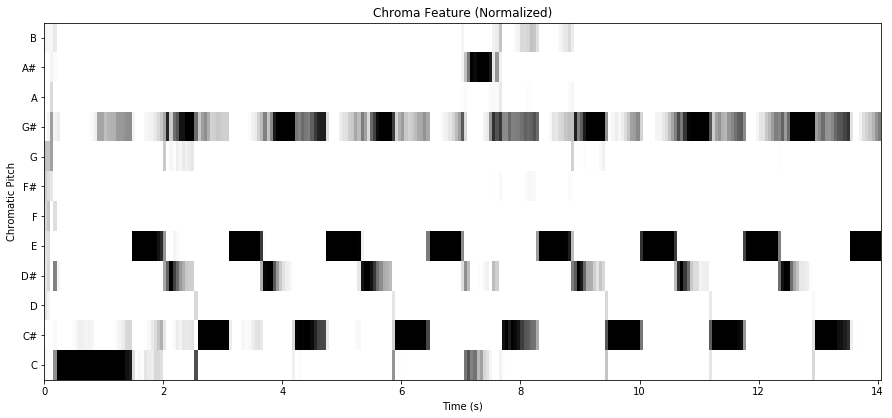

In [16]:
fig = plt.figure(figsize=(15,8))

plt.imshow(new, origin="lower", cmap="Greys", vmin=0.2,vmax=0.8,aspect=.5,extent =[0,14.0625,-.5,11.5])
labels = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
plt.yticks(np.linspace(0,11,12),labels)
plt.ylabel("Chromatic Pitch")
plt.xlabel("Time (s)")
plt.title("Chroma Feature (Normalized)")

plt.show()

In [17]:
#1 slice = 5000 samples (windowlength)
#1 second = 48000 samples
#default overlap for time slices is 1/2
#then slices per second = 2*rate/windowlength
sps = (2*rate)/(windowlen)
video_length = len(t)/sps

video_array = chromagram.copy()
video_array = np.append(video_array,np.zeros((12,30)), axis=1)

fig = plt.figure(figsize = (11,6))
labels = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
plt.yticks(np.linspace(0,11,12),labels)
plt.xticks(())
plot = plt.imshow(video_array, origin="lower", cmap="Greys", vmin=40000, vmax=1000000000000, aspect=8)


def animate(frame): 
    plot.set_data(video_array[:,frame:frame + 30])
anim = FuncAnimation(fig, animate, frames=len(t), interval = (1/sps)*1000)
video = anim.to_html5_video()
plt.close()
display.HTML(video)

Notice how the beginning of the piece has a rather harsh strike on the C# bass note. This will alter the initial frequencies a bit, and will make it more difficult for our program to tell what note is being played. Also, keep in mind that bass frequencies have a smaller bandwidth and are therefore more prone to being smeared into neighboring pitches when the transform is applied. The same thing happens about halfway through when the B note is struck. 